In [1]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters as filters
import skimage.segmentation as seg
import skimage.color as color
import skimage.feature as feature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from IPython.display import display

In [2]:
def plot_images(imgs, titles, overlays=None, overlay_alpha=0.3, **kwargs):
    f, axes = plt.subplots(1, len(imgs))
    f.set_size_inches(15, 5)

    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], **kwargs)
        axes[i].set_title(titles[i])
        
        if overlays:
            axes[i].imshow(overlays[i], cmap='gray', alpha=overlay_alpha)

---
# Input data

In [3]:
aca_jz = cv.imread('./data/sample/ACA+jąderka+ziarnisty(HEp2IIF)1.png')
ama = cv.imread('./data/sample/aca+ama.png')
aca = cv.imread('./data/sample/ACA-1.png')

imgs = [aca_jz, ama, aca]
titles = ['ACA+jąderka+ziarnisty', 'AMA', 'ACA']

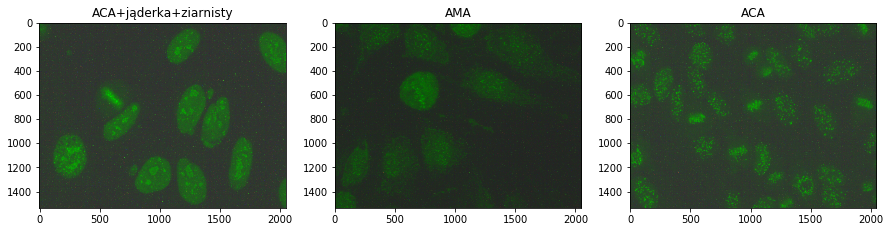

In [4]:
plot_images(imgs, titles)

---
# Preprocessing

### Channels reduction

In [5]:
def channel_reduction(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [6]:
imgs_grayscale = [channel_reduction(img) for img in imgs]

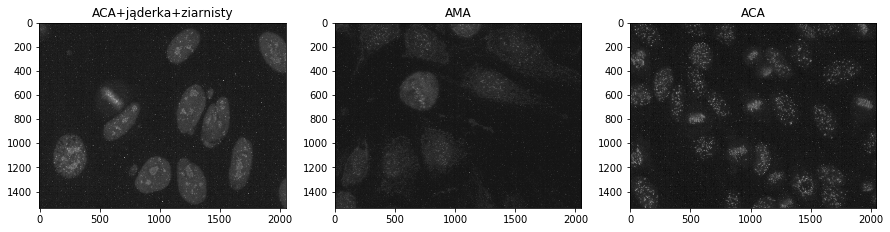

In [7]:
plot_images(imgs_grayscale, titles, cmap='gray')

### Resizing

In [8]:
def resize(img, size):
    return cv.resize(img, dsize=size, interpolation=cv.INTER_CUBIC)

In [9]:
imgs_resized = [resize(img, (800, 600)) for img in imgs_grayscale]

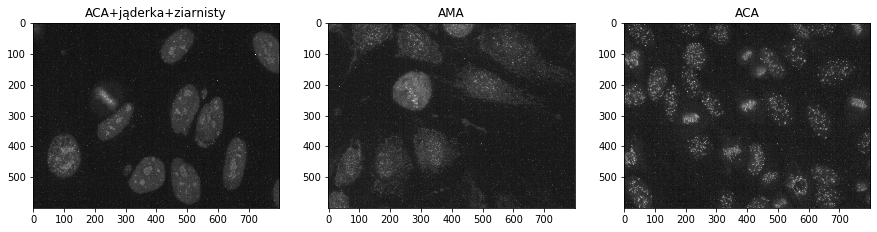

In [10]:
plot_images(imgs_resized, titles, cmap='gray')

### Denoising

In [11]:
def denoise(img, h=5):
    return cv.fastNlMeansDenoising(img, h=h)

In [12]:
imgs_denoised = [denoise(img) for img in imgs_resized]

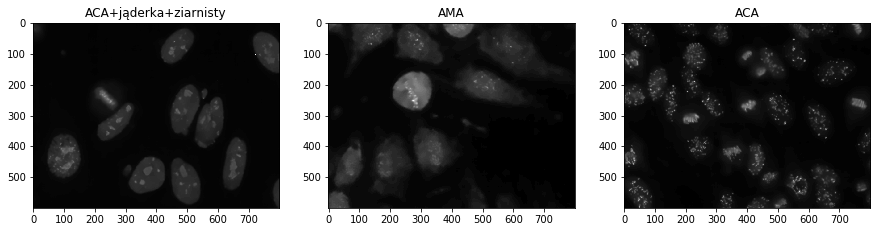

In [13]:
plot_images(imgs_denoised, titles, cmap='gray')

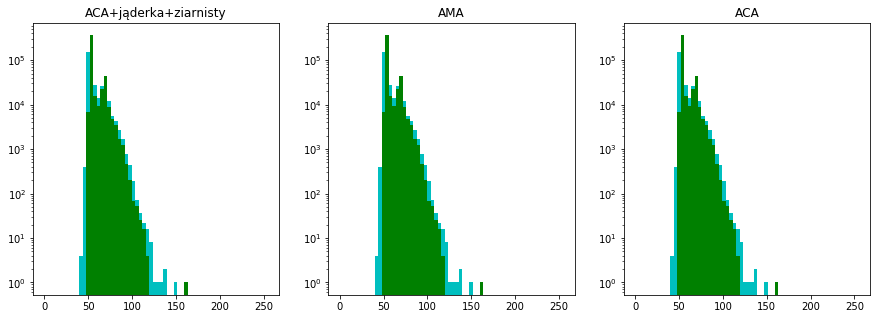

In [14]:
f, axes = plt.subplots(1, len(imgs))
f.set_size_inches(15, 5)

for i in range(len(imgs)):
    axes[i].hist(imgs_resized[0].ravel(), bins=64, range=(0, 255), color='c')
    axes[i].hist(imgs_denoised[0].ravel(), bins=64, range=(0, 255), color='g')
    axes[i].set_yscale('log')
    axes[i].set_title(titles[i])

### Normalization

In [15]:
def normalize(img):
    min_value = np.amin(img)
    max_value = np.amax(img)
    img = (img - min_value) * (255 / (max_value - min_value))
    return img.astype(np.uint)

In [16]:
imgs_norm = [normalize(img) for img in imgs_denoised]

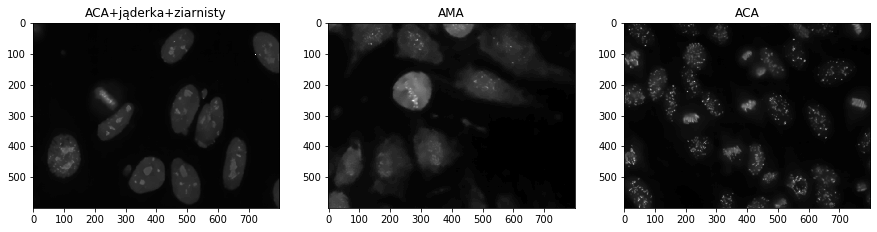

In [17]:
plot_images(imgs_norm, titles, cmap='gray')

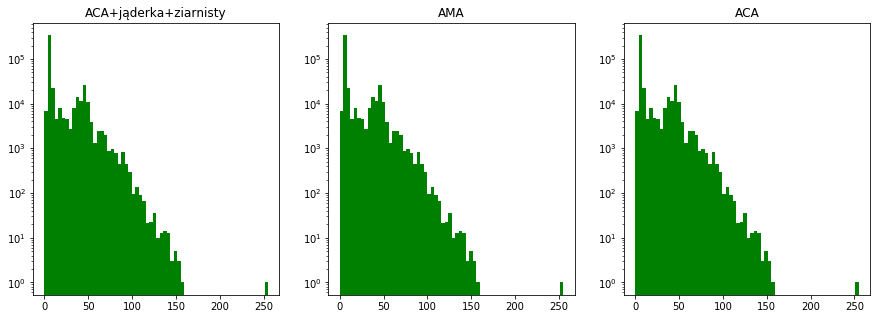

In [18]:
f, axes = plt.subplots(1, len(imgs))
f.set_size_inches(15, 5)

for i in range(len(imgs)):
    axes[i].hist(imgs_norm[0].ravel(), bins=64, range=(0, 255), color='g')
    axes[i].set_yscale('log')
    axes[i].set_title(titles[i])

---
# Segmentation

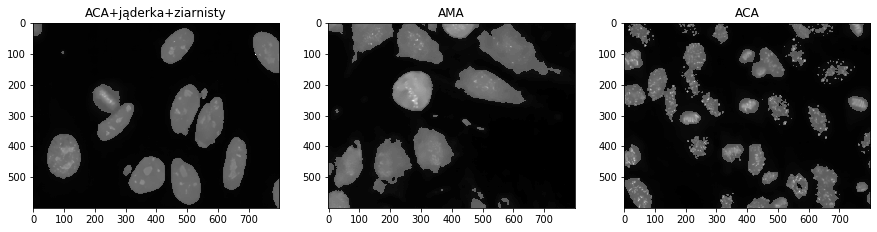

In [19]:
plot_images(
    imgs_norm,
    titles,
    [img > filters.threshold_li(img) for img in imgs_norm],
    cmap='gray',
    overlay_alpha=0.3
)

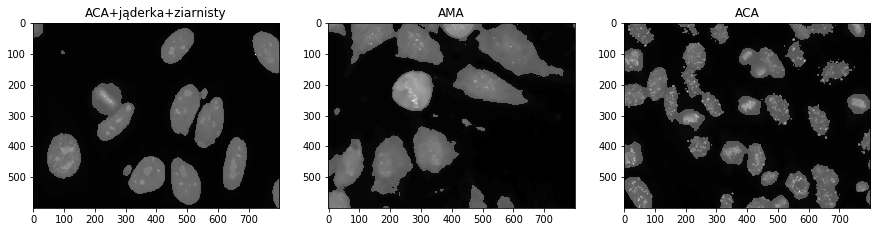

In [20]:
plot_images(
    imgs_norm,
    titles,
    [img > filters.threshold_mean(img) for img in imgs_norm],
    cmap='gray',
    overlay_alpha=0.3
)

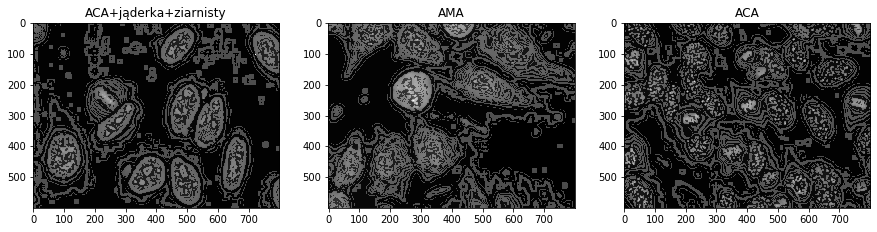

In [21]:
plot_images(
    imgs_norm,
    titles,
    [img > filters.threshold_niblack(img) for img in imgs_norm],
    cmap='gray',
    overlay_alpha=0.3
)

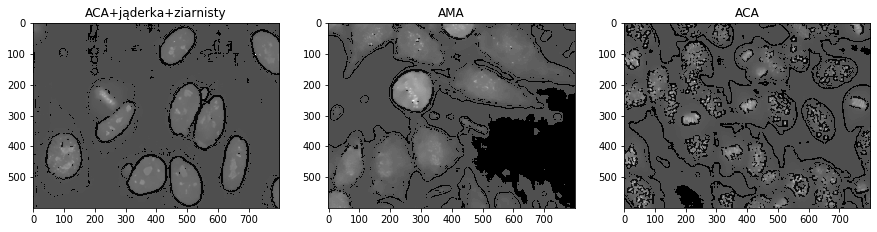

In [22]:
plot_images(
    imgs_norm,
    titles,
    [img > filters.threshold_sauvola(img) for img in imgs_norm],
    cmap='gray',
    overlay_alpha=0.3
)

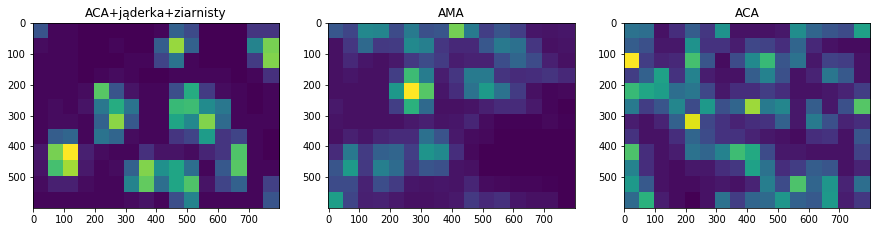

In [34]:
labels = [color.label2rgb(seg.slic(img, n_segments=200), img, kind='avg') for img in imgs_norm]
plot_images(labels, titles)

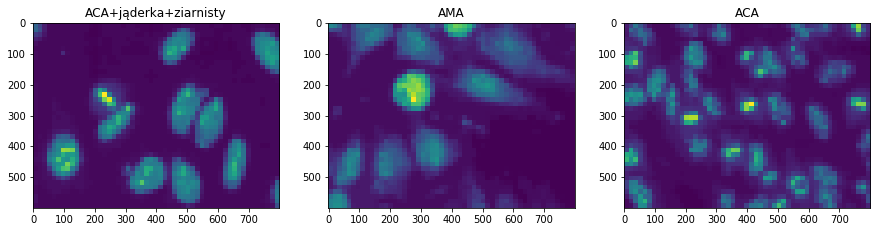

In [24]:
labels = [color.label2rgb(seg.slic(img, n_segments=2000), img, kind='avg') for img in imgs_norm]
plot_images(labels, titles)

---
# Texture futures extraction

In [25]:
def get_shade(img, locs, size, shade=None):
    
    if shade is None:
        shade = np.zeros(img.shape, dtype=bool)
        
    for loc in locs:
        top, left = loc
        height, width = size
        shade[top:top+height, left:left+width] = True
        
    return shade

def texture_features(img, locs, rows, cols, stride, params):
    results = [[] for _ in range(len(params))]
    
    for loc in locs:
        top, left = loc
        
        for r in range(rows):
            for c in range(cols):
                t = top + r * stride
                l = left + c * stride
                patch = img[t:t+stride, l:l+stride] / 255 * 8
                patch = patch.astype(np.int8)

                glcm = feature.greycomatrix(patch, [5], [0], levels=9, symmetric=True, normed=True)
                
                for i, p in enumerate(params):
                    results[i].append(feature.greycoprops(glcm, p)[0, 0])

    return np.array(results)

def perform_pca(data, number_of_components, scale=False):
    
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    pca = PCA(n_components=number_of_components)
    components = pca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    
    return components_dataframe, pca

In [26]:
rows, cols = 1, 1
stride = 50
size = stride * rows, stride * cols
locs = [
    [(450, 350), (470, 460), (420, 620), (320, 220)],
    [(30, 240), (380, 310), (170, 480), (50, 270)],
    [(180, 190), (365, 205), (240, 465), (500, 550)]
]

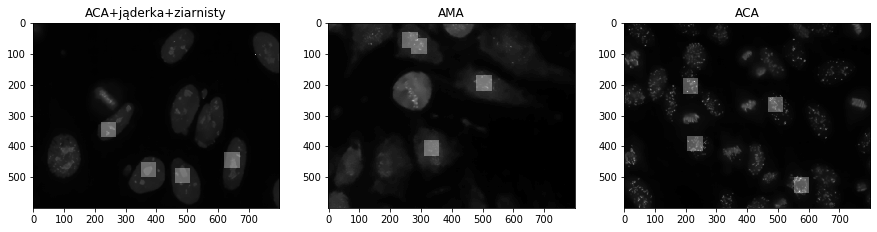

In [27]:
overlays = [
    get_shade(img, loc, size)
    for img, loc in zip(imgs_norm, locs)
]
plot_images(imgs_norm, titles, overlays, cmap='gray', overlay_alpha=0.3)

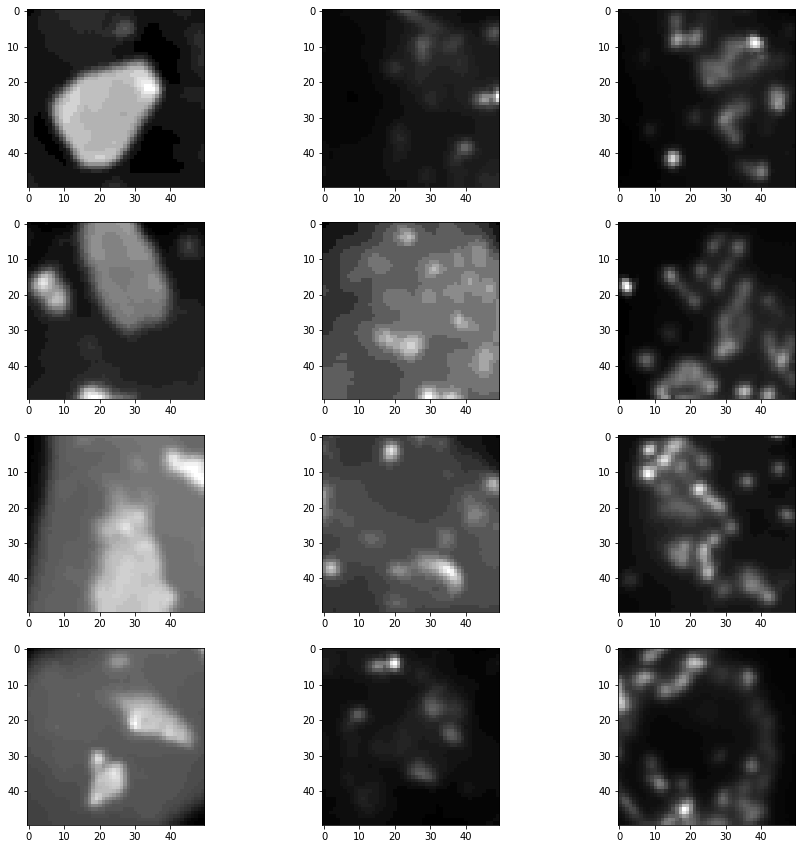

In [28]:
f, axes = plt.subplots(len(locs[0]), len(locs))
f.set_size_inches(15, 15)

for i in range(len(locs)):
    for j in range(len(locs[i])):
        top, left = locs[i][j]
        height, width = size
        axes[j][i].imshow(imgs_norm[i][top:top+height, left:left+width], cmap='gray')

In [29]:
p = ['dissimilarity', 'correlation', 'contrast', 'ASM', 'homogeneity']
features = [
    texture_features(img, loc, rows, cols, stride, p)
    for img, loc in zip(imgs_norm, locs)
]
features_combined = np.concatenate(features, axis=1)

In [30]:
for title, f in zip(titles, features):
    display(pd.DataFrame(data={p[i]: f[i] for i in range(len(p))}))
    print(title)

,dissimilarity,correlation,contrast,ASM,homogeneity
0,0.125333,0.656867,0.125333,0.525113,0.937333
1,0.178667,0.394761,0.178667,0.558055,0.910667
2,0.237778,0.545038,0.237778,0.391014,0.881111
3,0.167556,0.421078,0.183556,0.607531,0.917822


ACA+jąderka+ziarnisty


,dissimilarity,correlation,contrast,ASM,homogeneity
0,0.212889,0.335321,0.260889,0.581084,0.898293
1,0.194667,0.604311,0.196444,0.350845,0.902844
2,0.232000,0.560601,0.269333,0.328772,0.887733
3,0.327111,0.357281,0.489778,0.441027,0.850603


AMA


,dissimilarity,correlation,contrast,ASM,homogeneity
0,0.488000,0.297427,0.878222,0.324879,0.792321
1,0.448444,0.379939,0.648444,0.229713,0.795054
2,0.519111,0.375274,0.755556,0.225432,0.763838
3,0.710222,0.335030,1.250667,0.160777,0.695788


ACA


In [31]:
components, _ = perform_pca(features_combined.T, number_of_components=2, scale=True)
components

,0,1
0,-2.605199,-0.955869
1,-1.552794,1.011172
2,-1.035874,-0.748824
3,-1.842292,1.029501
4,-1.150707,1.516612
5,-1.419996,-1.310046
6,-0.918351,-1.099574
7,0.175026,0.765730
8,2.097249,0.687840
9,1.676603,-0.287112


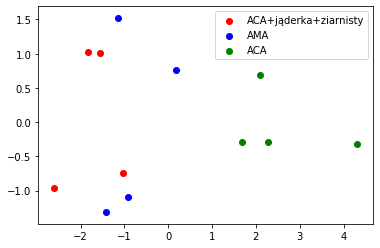

In [32]:
colors = ['red', 'blue', 'green']

for i in range(len(imgs_norm)):
    plt.scatter(components[0][i*4:(i+1)*4], components[1][i*4:(i+1)*4], c=colors[i], label=titles[i])
plt.legend()